In [1]:
#Import dependencies
import numpy as np
import math
import random
import matplotlib.pyplot as plt #for plotting functions
from scipy.special import erfc
from numpy import sum,isrealobj,sqrt
from numpy.random import standard_normal
from scipy.special import erfc

### Required Functions ###

In [2]:
#BPSK Modulation
def bpsk_mod(mu,L):
    from scipy.signal import upfirdn
    s_bb = upfirdn(h=[1]*L, x=2*mu-1, up = L) # NRZ encoder; upfirdn: Upsample, FIR filter, and downsample.
    t=np.arange(start = 0,stop = len(mu)*L) #discrete time base
    return (s_bb,t)

### More Required Functions ###

In [4]:
#Pathloss Model - Log distance
def logNormalShadowing(Pt_dBm,Gt_dBi,Gr_dBi,f,d0,d,L,sigma,n):
    #Pt_dBm = Transmitted power in dBm
    #G_BD_dBi = Gain of the BD antenna in dBi
    #G_AP_dBi = Gain of the AP antenna in dBi
    #f = frequency of transmitted signal in Hertz
    #d0 = reference distance of receiver from the transmitter in meters
    #d = array of distances at which the loss needs to be calculated
    #L = Other System Losses, for no Loss case L=1
    #sigma = Standard deviation of log Normal distribution (in dB)
    #n = path loss exponent
    #Pr_dBm = Received power in dBm
    #PL = path loss due to log normal shadowing
    lamda_ = (3*10**8)/f #Wavelength in meters
    K = 20*math.log10(lamda_/(4*np.pi)) - 10*n*math.log10(d0) - 10*math.log10(L) #path-loss factor
    X = sigma*np.random.randn() #normal random variable
    PL = Gt_dBi + Gr_dBi + K -10*n*math.log10(d/d0) - X  #PL(d) including antennas gains
    #Pr_dBm = Pt_dBm + PL #Receieved power in dBm at d meters
    return PL


#AP-BD Channel Gain
def APBD_ChannelGain(f):
    Pt_dBm = 30 #1W AP transmission power 1W = 30dBm
    Gt_dBi = 1 #Gain of the AP antenna in dBi 
    Gr_dBi = 1 #Gain of the BD antenna in dBi
    d0 = 1 #reference distance of receiver from the transmitter in meters
    d = 10 #distance between AP and BD
    L = 1 #Other System Losses, for no Loss case L=1
    sigma=2 #Standard deviation of log Normal distribution (in dB)
    n=2 # path loss exponent
    PG_dBi = - logNormalShadowing(Pt_dBm,Gt_dBi,Gr_dBi,f,d0,d,L,sigma,n)
    return PG_dBi

#J-AP Channel Gain
def JAP_ChannelGain(f):
    M = 5
    P_J = np.random.randint(low=1,high=M,dtype = int) #choose a number between 1-4
    Pt_dBm = 10*math.log10(P_J*1000) #selecting random jamming power between 1W - 4W
    Gt_dBi = 1 #Gain of the J antenna in dBi 
    Gr_dBi = 1 #Gain of the AP antenna in dBi
    d0 = 1 #reference distance of receiver from the transmitter in meters
    d = 100 #distance between J and AP
    L = 1 #Other System Losses, for no Loss case L=1
    sigma=2 #Standard deviation of log Normal distribution (in dB)
    n=2 # path loss exponent
    PG_dBi = - logNormalShadowing(Pt_dBm,Gt_dBi,Gr_dBi,f,d0,d,L,sigma,n)
    return PG_dBi

#J-BD Channel Gain
def JBD_ChannelGain(f):
    M = 5
    P_J = np.random.randint(low=1,high=M,dtype = int) #choose a number between 1-4
    Pt_dBm = 10*math.log10(P_J*1000) #selecting random jamming power between 1W - 4W
    Gt_dBi = 1 #Gain of the J antenna in dBi 
    Gr_dBi = 1 #Gain of the BD antenna in dBi
    d0 = 1 #reference distance of receiver from the transmitter in meters
    d = 100 #distance between J and BD
    L = 1 #Other System Losses, for no Loss case L=1
    sigma=2 #Standard deviation of log Normal distribution (in dB)
    n=2 # path loss exponent
    PG_dBi = - logNormalShadowing(Pt_dBm,Gt_dBi,Gr_dBi,f,d0,d,L,sigma,n)
    return PG_dBi

#Loopback Channel Gain (SIC)
def loopback_Channel():
    epsilon = 1e-10 #very small number
    Pt_dBm = 30 #should be same as AP transmission power
    #g_hat: feedback channel coefficient
    #g_bar = 7e-5 #g_bar: feedback channel coefficient estimation
    #g_tilde = 6e-5#g_tilde: estimation error
    #g_hat = g_bar + (sqrt(epsilon))*g_tilde 
    G = 1 #E[g_tilde**2]=1
    sigma = np.random.normal(loc=0.0, scale=1.0, size=None)
    phi = 30 #dBm 30dBm reduction = 60dB reduction, by current techniques, it has been reported that SI can be canceled up to −81 dB in analog domain
    combined_power = (Pt_dBm*phi) + sigma**2
    P = combined_power*epsilon*G
    return P

### System Parameters ###

In [5]:
#System parameters
N=10000 # Number of symbols to transmit
L=16 # oversampling factor,L=Tb/Ts(Tb=bit period,Ts=sampling period) Tb (bit period) = symbol duration = (1/900MHz) = 1.1ns
deltaf = 10e6 #frequency step
Fc = 900e6 #900MHz #base carrier frequency
Fs=L*Fc # sampling frequency

#### AP and Jammer Signal ####

In [6]:
### numpy.random.randn => Return a sample (or samples) from the “standard normal” distribution. 
#[Recall: The standard normal distribution is a specific type of normal distribution where the mean is equal to 0 
#and the standard deviation is equal to 1.]
### numpy.random.normal => Draw random samples from a normal (Gaussian) distribution. 

x = (np.random.randn(N*L) + 1j*np.random.randn(N*L))/np.sqrt(2) #Complex Gaussian with unity power of size N*L (N: # of symbols generated)
x_J = (np.random.randn(N*L) + 1j*np.random.randn(N*L))/np.sqrt(2) #Complex Gaussian with unity power of size N*L (N: # of symbols generated)

### Noise ###

In [7]:
#random.normal(loc=0.0, scale=1.0, size=None); loc => mean, scale => Standard deviation of the distribution (must be non-negative
def complex_noise(mean, variance, size):
    # Generate real and imaginary parts separately with normal distribution
    real_part = np.random.normal(mean, np.sqrt(variance), size)
    imag_part = np.random.normal(mean, np.sqrt(variance), size)
    
    # Combine real and imaginary parts into complex numbers
    complex_noise = real_part + 1j * imag_part
    
    return complex_noise

### State Space, Action Space ###

In [8]:
# BD - learning agent:
#State: {E_B}: energy/battery level, we can discretize it. {1, 2, ..., L}
#Action: harvesting or backscatter, e.g., {harvesting: 0; backscatter: 1}
#Reward: {backscattered: reward 1; otherwise: reward 0}; This will not reflect the true throughput since the backscatter could be jammed.
#Then BD can adopt Q-learning
    
M = 10 #set number of jammer power level i.e. Jammer shuffles between M power levels

def battery_state(mu):
    
    P_T = 1 #AP transmission power: 1W
    #M = 10 #Jammer power level upper limit
    P_J = np.random.randint(low=0,high=M,dtype = int) #choose a number between 0 to M-1
    τ = 1#e-3 #duration of 1 time slot = 1ms
    ξ = 0.8 #energy harvesting efficiency
    #levels = 5 #5 discrete levels of BD energy
    #E_levels = np.arange(1, levels+1, 1, dtype=int)
    U_E = ξ*(P_J + P_T)*τ#*E_levels #Unit Energy #Signal energy doesn't depend upon frequency
    E_BC = 0.75*U_E # Let 1 Unit energy used, fixed, by tag circuit during BC operation
    E_EH = 0.25*U_E # Let 1 Unit energy used, fixed, by tag circuit during EH operation ### E_BC > E_EH
    E_h = U_E #Amount of energy harvested #Energy harvested is function of time and power
    E_B = mu*E_BC - (1 - mu)*E_EH + (1 - mu)*E_h + 1*U_E
    return np.round(E_B)

state_space = [] #number of jammer power level = number of battery energy levels
action_space = np.array([0,1])
#print(P_J,E_B)
#state_space_list = state_space.tolist()

In [9]:
q_table = np.zeros((M, len(action_space)))
print(q_table)

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


### Trainning Phase

### Number of steps/time slots ###

In [10]:
#Number of steps each episode will have. 1 step = 1 time slot
nSteps = 400 #number of time steps, in each time step, AP chooses a new channel ## 1 time step = 1 time slot

In [11]:
#training parameters
#In this case, number of steps per episode = number of time slots per episode
#No terminating condition - each episode run up to "nSteps" - time slots
num_episodes = 600 #total no. of episodes the agent will play during training
max_steps_per_episode = nSteps #one of the terminating condition, max no. steps in a single episode

learning_rate = 0.1 #high LR focus more on new, less on old; low LR learn nothing, use prior knowledge
discount_rate = 0.99 #high DR focus more on distant reward, low DR focus more on immediate reward

#epsilon-greedy
exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.01

In [12]:
all_epochs = []
all_iterations = []
all_exploration_rate = []
rewards_all_steps = []
avg_reward_all_episodes = []
rewards_current_step = 0
iterations = 0
epochs = 0
reward = np.zeros(max_steps_per_episode)
P_R_AP = np.zeros(max_steps_per_episode)
P_N = np.zeros(max_steps_per_episode)
SNR = np.zeros(max_steps_per_episode)
EB = 0
# Q-learning algorithm
for episode in range(num_episodes):
    current_state = 0
    epochs += 1
    #rewards_current_step = 0
    rewards_each_episode = []
    #avg_reward = 0
    for step in range(max_steps_per_episode):
        iterations += 1
        # Exploration-exploitation trade-off
        p0 = random.uniform(0, 1)
        if p0 > exploration_rate:
            action = np.argmax(q_table[current_state][:]) 
            #print('Exploited Action: ',action)
        else:
            action = random.choice(action_space) #randomly choose between 0 and 1
            #print('Random Action: ',action)
        mu = action #action decides whether backscatter (action = 1) or harvest (action =0)
        
        if (EB>=14):
            mu = 1
        elif (EB<=1):
            mu = 0
        #(s_bb,t)= bpsk_mod(mu,L) # BPSK modulation(waveform) - baseband
        #k = 0 #fixed channel 
        #f_k = Fc + (k*deltaf)
        #reflection coefficient: s_bb = -1 for mu = 0=> non-reflecting state, s_bb = 1 for mu = 1=>reflecting state
        #unwanted_signal = (P_J*JAP_ChannelGain(f_k)*abs(x_J)) + loopback_Channel()*abs(x) + abs(noise((x+x_J),EbN0dB[step],L))
        #y_AP = ((s_bb[step]**2)*P_T*APBD_ChannelGain(f_k)*abs(x)) + ((s_bb[step]**2)*P_J*APBD_ChannelGain(f_k)*abs(x)*JBD_ChannelGain(f_k)*abs(x_J)) + \
        #unwanted_signal
        #P_R_AP[step] = sum(y_AP)/N
        #P_N[step] = sum(unwanted_signal)/N
        #SNR[step] =  P_R_AP[step]/P_N[step]
        #print('AP uses channel '+str(k)+' having frequency '+str(f_k))
        
        #next state
        EB = battery_state(mu) #calculate the EB value for this mu value at this time slot
               
        reward[step] = mu #reward = 1 when backscatters (i.e. action =1), reward = 0 when harvests (i.e. action =0)
        #print(reward[step])
        state_space.append(EB)
        state_space_sorted = list(dict.fromkeys(state_space)) #avoiding repetition of same EB values
        #print(state_space_sorted)
        new_state = state_space_sorted.index(EB) #retrieve the index number that matches with the EB values 
        #print(new_state)
        # Update Q-table for Q(s,a)
        q_table[current_state][action] = (1 - learning_rate) * q_table[current_state][action] + \
        learning_rate * (reward[step] + discount_rate * np.max(q_table[new_state][:]))
        
        # Transition to the next state
        current_state = new_state
        # Add new reward        
        rewards_current_step = reward[step]
        #print(rewards_current_step)
        rewards_each_episode.append(rewards_current_step)
        rewards_all_steps.append(rewards_current_step)
        
        all_iterations.append(iterations)
    avg_reward = sum(rewards_each_episode)/max_steps_per_episode
    avg_reward_all_episodes.append(avg_reward)
    # Exploration rate decay (at the end of one episode, we need to update the exploration rate)
    exploration_rate = min_exploration_rate + \
    (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*episode)
    all_epochs.append(epochs)
    all_exploration_rate.append(exploration_rate)



In [13]:
# Print updated Q-table
print("\n\n********Q-table********\n")
print(q_table)



********Q-table********

[[88.78768783 89.58917857]
 [88.91764084 89.678564  ]
 [89.03747396 89.71377566]
 [89.4459976  89.55637154]
 [89.13071729 89.65669447]
 [88.94432605 89.51314761]
 [88.93306375 89.67781374]
 [88.80175472 89.69973418]
 [89.01404179 89.63534793]
 [88.37681178 88.67659953]]


## Plots ##

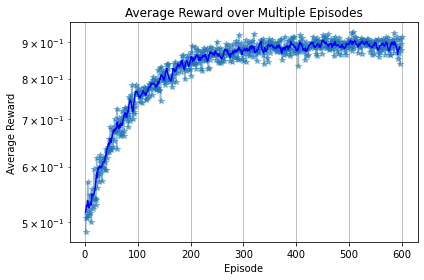

In [21]:
# import numpy as np
# import matplotlib.pyplot as plt

# Example data (replace this with your own data)
# episodes = np.arange(1, 101)  # episode numbers
# real_rewards = np.random.normal(0, 1, size=(100,))  # replace with your actual rewards

# Function to calculate a simple moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Set the window size for smoothing
window_size = 5

# Calculate the moving average of real rewards
smoothed_rewards = moving_average(avg_reward_all_episodes, window_size)

fig1, ax1 = plt.subplots(nrows=1,ncols = 1)
ax1.semilogy(all_epochs,avg_reward_all_episodes,'-*', alpha=0.5)
ax1.set_xlabel(r'Episode')
ax1.set_ylabel(r'Average Reward')
ax1.set_title('Average Reward over Multiple Episodes')
plt.grid(True)


# Plot the original real rewards with reduced opacity
# plt.plot(episodes, real_rewards, label='Real Rewards', color='blue', alpha=0.5)

# Plot the smoothed rewards
plt.plot(all_epochs[:-window_size+1], smoothed_rewards, label=f'Smoothed Rewards (Window Size={window_size})', color='blue')

# Add labels and legend
# plt.xlabel('Episode')
# plt.ylabel('Reward')
# plt.title('Average Reward vs Episode with Smoothed Rewards')
# plt.legend()

# Show the plot
# plt.show()
plt.tight_layout()
save_results_to = 'C:/Users/Zunayeed/Desktop/PhD/WICL/NSF-AoF Project/Simulation BC EH/New Plots/Throughput/'
plt.savefig(save_results_to + 'Avg_Reward_400S_600E.png', dpi = 300)

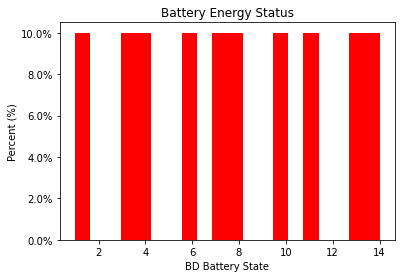

In [19]:
# import numpy as np
# import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# Generate an array of random values (replace this with your actual data)
# data = np.random.randn(400)

# Plot the histogram
plt.hist(state_space_sorted, bins=20, weights=np.ones(len(state_space_sorted)) / len(state_space_sorted), color = 'red')
# plt.hist(data, weights=np.ones(len(data)) / len(data))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

# Add labels and title
plt.xlabel('BD Battery State')
plt.ylabel('Percent (%)')
plt.title('Battery Energy Status')

# plt.savefig('BD_Bat_Static_400S_200E.png')
save_results_to = 'C:/Users/Zunayeed/Desktop/PhD/WICL/NSF-AoF Project/Simulation BC EH/New Plots/Energy/'
plt.savefig(save_results_to + 'BD_Bat_BD_Learning_Agent.png', dpi = 300)

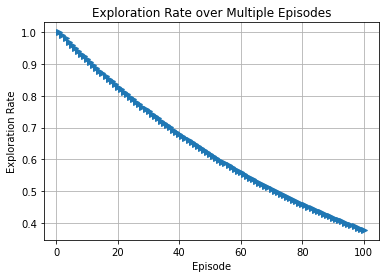

In [14]:
#Plotting exploration rate over 100 episodes

plt.plot(all_epochs,all_exploration_rate,'->') 
plt.xlabel(r'Episode')
plt.ylabel(r'Exploration Rate')
plt.title('Exploration Rate over Multiple Episodes')
plt.grid(True)

#plt.savefig('exploration_rate.png')